In [1]:
import pymanopt
from pymanopt.manifolds import Product, Euclidean,  Grassmann
from pymanopt import Problem
from pymanopt.solvers import ConjugateGradient#, SteepestDescent

import math

%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
alpha=45

orig_dim=500
latent_dim=5 # dimensionality of the latent space


In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 74
    train_number_epochs = 10

In [5]:
# This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

class TripletNetworkDataset(Dataset): # TripletNetworkDataset inherits torch.utils.data.Dataset
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index): # subclasses should overwrite __getitem__()
        img0_tuple = random.choice(self.imageFolderDataset.imgs) #pick any random image from the list
        #we need to make sure approx 50% of images are in the same class
        #should_get_same_class = random.randint(0,1) #randomly pick 0 or 1
        #if should_get_same_class:
        while True:
            #keep looping till the same class image is found
            img1_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img0_tuple[1]==img1_tuple[1]: #labels are in element 1
                break
        #else:
        while True:
            #keep looping till a different class image is found

            img2_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img0_tuple[1] !=img2_tuple[1]:
                break

        img0 = Image.open(img0_tuple[0]) #images are in element 0
        img1 = Image.open(img1_tuple[0])
        img2 = Image.open(img2_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        img2 = img2.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
            img2 = PIL.ImageOps.invert(img2)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img0, img1 , img2
        # 0 for same class, 1 for difft class
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

#print(type(folder_dataset),folder_dataset)

In [7]:
triplet_dataset = TripletNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)


#print(type(triplet_dataset.imageFolderDataset.imgs),len(triplet_dataset.imageFolderDataset.imgs),triplet_dataset.imageFolderDataset.imgs)

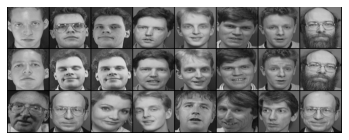

In [8]:
# The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image. 
# 1 indiciates dissimilar, and 0 indicates similar.

vis_dataloader = DataLoader(triplet_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)

#print(type(vis_dataloader),vis_dataloader)

dataiter = iter(vis_dataloader)
#print(type(dataiter),dataiter)

example_batch = next(dataiter)
#print('example_batch:',type(example_batch),len(example_batch)) #list type

# print(type(example_batch[0]),example_batch[0].size(),len(example_batch[0])) # anchors tensor: (batchsz,#channels,width,height)
# print(type(example_batch[1]),example_batch[1].size(),len(example_batch[1])) # pos/negs tensor: (b,c,w,h)
# print(type(example_batch[2]),example_batch[2].size(),len(example_batch[2])) # labels tensor: (batchsz,1)

concatenated = torch.cat((example_batch[0],example_batch[1],example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated))
#print(example_batch[2].numpy())

In [9]:
class TripletNetwork(nn.Module):
    def __init__(self):
        super(TripletNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, orig_dim),
            nn.ReLU(inplace=True),

            nn.Linear(orig_dim, orig_dim), # P: Final linear layer of the CNN
            nn.ReLU(inplace=True) )
        
#         self.fc2 = nn.Sequential(
#             nn.Linear(orig_dim, latent_dim,bias=False)) # Linear embedding layer (for DML)

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1) #flatten the output, for inputting to linear layer
        embed = self.fc1(output) # the nonlinear embedding/ descriptor for an image
        #output = self.fc2(embed)
        return embed#output, embed #

    def forward(self, input1, input2, input3):
        embed1 = self.forward_once(input1)
        embed2 = self.forward_once(input2)
        embed3 = self.forward_once(input3)
        return embed1, embed2, embed3

In [10]:
class TripletLoss(torch.nn.Module):
    """
    Triplet loss function.
    Based on: FaceNet: A unified embedding for face recognition and clustering

    """

    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, output3):
        anc_pos_distance = F.pairwise_distance(output1, output2, keepdim = True) # output1:(b,d),output2:(b,d)
        anc_neg_distance = F.pairwise_distance(output1, output3, keepdim = True) # output1:(b,d),output2:(b,d)
        
        #print(euclidean_distance.size()) # (b,1) pairwise distances tensor
#         blah=((1-label) * torch.pow(euclidean_distance, 2) +
#                                       (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        #print('blah:',blah.size()) ## (b,1) tensor
        loss_triplet = torch.mean(torch.pow(torch.clamp(anc_pos_distance+self.margin - anc_neg_distance, min=0.0), 2))
        print('loss_triplet:',loss_triplet) # tensor of no size, but an item containing the scalar loss 

        return loss_triplet

In [11]:
class gumlLoss(torch.nn.Module):
    """
    GUML loss function.
    Based on: 

    """

    def __init__(self, alpha=45):
        super(gumlLoss, self).__init__()
        self.alpha = alpha

    def forward(self, embed1, embed2, embed3, R_tensor,L_tensor):

        xi_ancs=embed1.transpose(0,1)
        xi_poss=embed2.transpose(0,1)
        xi_negs=embed3.transpose(0,1) #(d,b) format, b:#triplets in mini-batch, i.e., batch size

        #print(xi_ancs.size(),xi_poss.size(),xi_negs.size())
        #print(xi_ancs.requires_grad,xi_poss.requires_grad,xi_negs.requires_grad)

        R_tensor=torch.from_numpy(R) # (d,l) format, d:orig_size, l:new_size of embeddings
        L_tensor=torch.from_numpy(L)

        #print(R_tensor.size(),L_tensor.size())
        #print(R_tensor.requires_grad,L_tensor.requires_grad)

        xi_avgs=0.5*(xi_ancs+xi_poss) #dxT, T:#triplets
        #print(xi_avgs.size())
        #print(xi_avgs.requires_grad)

        num_triplets=xi_avgs.size(1)
        #print(num_triplets)


        RRT=R_tensor@(R_tensor.transpose(0,1))
        #print(RRT.size(),RRT.dtype)


        listA=xi_ancs.transpose(0,1)#.tolist()
        listB=xi_poss.transpose(0,1)#.tolist()



        #print(listA.dtype,type(listA))

        exps_plus=list(map(lambda elA, elB:
                   torch.exp(-(elA@RRT@elB)), 
                   listA.double(), listB.double()))
        #exps_plus=list(map(lambda elt: np.asscalar(elt), exps_plus))
        exps_plus=torch.tensor(exps_plus).reshape(1,len(exps_plus))

        #print(exps_plus,exps_plus.size())

        listA=xi_avgs.transpose(0,1)
        listB=xi_negs.transpose(0,1)

        exps_minus=list(map(lambda elA, elB:
                    torch.exp(-(elA@RRT@elB)),
                    listA.double(), listB.double()))
        #exps_minus=list(map(lambda elt: np.asscalar(elt), exps_minus))
        exps_minus=torch.tensor(exps_minus).reshape(1,len(exps_minus))

        w_is_plus = 1/(1+ exps_plus ) # weights
        w_is_minus = 1-1/(1+ exps_minus ) # weights

        w_is=0.5*(w_is_plus+w_is_minus) 
        #print(w_is,w_is.size())    

        LT=L_tensor.transpose(0,1)

        delZaZp=xi_ancs-xi_poss
        MhZaZp = LT @ delZaZp.double()
        d_aps=torch.sum(MhZaZp*MhZaZp,0)
        d_aps=d_aps.reshape(1,len(d_aps)) # 1xT
        #print(delZaZp.shape,MhZaZp.shape,d_aps.shape)

        delZnZm=xi_negs-xi_avgs
        MhZnZm = LT @ delZnZm.double()
        d_nms=torch.sum(MhZnZm*MhZnZm,0)
        d_nms=d_nms.reshape(1,len(d_nms)) # 1xT

        tan_sq_alpha=(math.tan(math.radians(alpha)))**2 # for angular 

        z_is=d_aps-4*tan_sq_alpha*d_nms # metric losses

        #print(z_is.shape)

        m_is=torch.log(1+torch.exp(z_is))

        f_is=-w_is*m_is
        #print(f_is.shape)

        loss_guml= (1/num_triplets)*torch.sum(torch.log(1+torch.exp(-f_is)))

        #print(loss_guml)
        return loss_guml

In [12]:
train_dataloader = DataLoader(triplet_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size,drop_last = True)

In [13]:
#print(type(train_dataloader),train_dataloader)

In [14]:
net = TripletNetwork()#.cuda()
#criterion = TripletLoss()
criterion = gumlLoss()
#optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

# if only those parameters need to be updated for which requires_grad=True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr = 0.0005 )



In [15]:
counter = []
loss_history = [] 
iteration_number= 0

In [16]:
# net.parameters()
# for param in net.parameters():
#     #param.requires_grad = False
#     #print(param.size())
#     print(param)

In [17]:

print(net.fc1)
print(net.fc1[2].weight.data, net.fc1[2].weight.size())

##net.fc1[4].weight.requires_grad=False #making sure that the last affine layer is not updated during backprop

Sequential(
  (0): Linear(in_features=80000, out_features=500, bias=True)
  (1): ReLU(inplace)
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): ReLU(inplace)
)
tensor([[ 0.0141, -0.0003,  0.0370,  ..., -0.0023, -0.0339, -0.0034],
        [ 0.0213,  0.0209, -0.0255,  ..., -0.0022,  0.0432, -0.0084],
        [-0.0192,  0.0164,  0.0249,  ..., -0.0361, -0.0401, -0.0307],
        ...,
        [ 0.0379,  0.0299,  0.0296,  ..., -0.0004, -0.0061,  0.0107],
        [-0.0065, -0.0104, -0.0270,  ...,  0.0031, -0.0335, -0.0043],
        [ 0.0244, -0.0120,  0.0426,  ...,  0.0412,  0.0009, -0.0200]]) torch.Size([500, 500])


In [18]:
# print(net.fc1)
# print(net.fc1[4].weight, net.fc1[4].weight.size())

# L=np.ones((500,5))
# #net.fc1[4].weight=torch.from_numpy(L.T)

# with torch.no_grad():
#     #net.fc1[4].weight.copy_(torch.from_numpy(L.T).float())
#     # or
#     net.fc1[4].weight = nn.Parameter(torch.from_numpy(L.T).float())

#print(net.fc1[4].weight.data, net.fc1[4].weight.size())



In [19]:
manifold = Product([Euclidean(orig_dim, latent_dim), Grassmann(orig_dim, latent_dim)]) #list or tuples
#manifold = Product([Grassmann(orig_dim, latent_dim)]) #list or tuples

In [20]:
@pymanopt.function.PyTorch
def cost(R_tensor,L_tensor):

    xi_avgs=0.5*(xi_ancs+xi_poss) #dxT, T:#triplets
    #print('xi_avgs.size',xi_avgs.size())
    #print('xi_avgs.requires_grad',xi_avgs.requires_grad)

    num_triplets=xi_avgs.size(1)
    #print(num_triplets)


    RRT=R_tensor@(R_tensor.transpose(0,1))
    #print(RRT.size(),RRT.dtype)
    #print('type_R_tensor',type(R_tensor))


    listA=xi_ancs.transpose(0,1)#.tolist()
    listB=xi_poss.transpose(0,1)#.tolist()



    #print(listA.dtype,type(listA))

    exps_plus=list(map(lambda elA, elB:
           torch.exp(-(elA@RRT@elB)), 
           listA.double(), listB.double()))
    #exps_plus=list(map(lambda elt: np.asscalar(elt), exps_plus))
    exps_plus=torch.tensor(exps_plus).reshape(1,len(exps_plus))

    #print(exps_plus,exps_plus.size())

    listA=xi_avgs.transpose(0,1)
    listB=xi_negs.transpose(0,1)

    exps_minus=list(map(lambda elA, elB:
            torch.exp(-(elA@RRT@elB)),
            listA.double(), listB.double()))
    #exps_minus=list(map(lambda elt: np.asscalar(elt), exps_minus))
    exps_minus=torch.tensor(exps_minus).reshape(1,len(exps_minus))

    w_is_plus = 1/(1+ exps_plus ) # weights
    w_is_minus = 1-1/(1+ exps_minus ) # weights

    w_is=0.5*(w_is_plus+w_is_minus) 
    #print(w_is,w_is.size())    

    LT=L_tensor.transpose(0,1)

    delZaZp=xi_ancs-xi_poss
    MhZaZp = LT @ delZaZp.double()
    d_aps=torch.sum(MhZaZp*MhZaZp,0)
    d_aps=d_aps.reshape(1,len(d_aps)) # 1xT
    #print(delZaZp.shape,MhZaZp.shape,d_aps.shape)

    delZnZm=xi_negs-xi_avgs
    MhZnZm = LT @ delZnZm.double()
    d_nms=torch.sum(MhZnZm*MhZnZm,0)
    d_nms=d_nms.reshape(1,len(d_nms)) # 1xT

    tan_sq_alpha=(math.tan(math.radians(alpha)))**2 # for angular 

    z_is=d_aps-4*tan_sq_alpha*d_nms # metric losses

    #print(z_is.shape)

    m_is=torch.log(1+torch.exp(z_is))

    f_is=-w_is*m_is
    #print(f_is.shape)

    loss_guml= (1/num_triplets)*torch.sum(torch.log(1+torch.exp(-f_is)))

    #print(loss_guml)
    return loss_guml

In [21]:
problem = Problem(manifold=manifold, cost=cost)#, egrad=egrad)
# (3) Instantiate a Pymanopt solver
solver = ConjugateGradient( maxiter=5 , logverbosity=2) # logverbosity=2 for output of loss 

Mini-batch 0
Optimizing...
 iter		   cost val	    grad. norm
    0	+8.8252802104295658e-01	1.28696115e-02
    1	+8.6195910014184074e-01	3.00124566e-02
    2	+8.2302563643344095e-01	1.57325856e-02
    3	+8.1550497437138991e-01	1.14376095e-02
    4	+8.1159979634755020e-01	6.97610930e-03
Terminated - max iterations reached after 0.16 seconds.

Epoch number 0
 Current loss 0.8115997963475502

Mini-batch 1
Optimizing...
 iter		   cost val	    grad. norm
    0	+8.0078161357992250e-01	7.11492501e-02
    1	+7.7597179759769119e-01	3.53172521e-02
    2	+7.6888566724340934e-01	2.29724351e-02
    3	+7.6354883726292289e-01	1.24906893e-02
    4	+7.6005009951127844e-01	1.01369329e-02
Terminated - max iterations reached after 0.11 seconds.

Mini-batch 2
Optimizing...
 iter		   cost val	    grad. norm
    0	+7.3240814101542340e-01	1.33517857e-02
    1	+7.2846713423940479e-01	5.89928419e-03
    2	+7.2737326194255436e-01	4.24437255e-03
    3	+7.2636500476546006e-01	2.65581966e-03
    4	+7.255715282405832

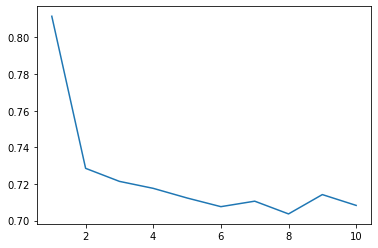

In [22]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        #print('i=',i,' data:',type(data),len(data))
        print('Mini-batch {}'.format(i))
        img0, img1 , img2 = data #data is a list with 3 tensor elements: anchors, positives/negatives, labels
        # img0: (b,c,h,w) tensor, img1: (b,c,h,w) tensor , label: (b,1) tensor
        
        #print(type(img0),type(img1),type(label),img0.size(), img1.size() , label.size())
        #img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        
        optimizer.zero_grad()
        
        embed1, embed2, embed3 = net(img0,img1,img2) # first extract features to learn the embedding matrix
        # (b,d) tensors, b:batch size, d:embedding size
        
        embed1 = F.normalize(embed1, p=2, dim=1) #l2 normalize the batch
        embed2 = F.normalize(embed2, p=2, dim=1)
        embed3 = F.normalize(embed3, p=2, dim=1)
        
        xi_ancs=embed1.transpose(0,1).detach() # dxb tensors, b=T i.e. #triplets in mini-batch
        xi_poss=embed2.transpose(0,1).detach() # dxb
        xi_negs=embed3.transpose(0,1).detach() # dxb        
        
        ##>>>>>>>>>>>>>>>> Fix the remaining network, and learn (R,L) <<<<<<<<<<<<<<<<#
        ##>>>>>>>>>>>>>>>> learn (R,L) using Riemannian optimization (eg, RCGD) <<<<<<<<<<<<<<<<#
        if (epoch==0 and i==0):#for the very first mini-batch
            # let Pymanopt do the rest
            xopt, optlog = solver.solve(problem) # start with a random point on manifold
            R=xopt[0]
            L=xopt[1] #dxl
            #proj_matrix=L.T
        else:
            # let Pymanopt do the rest
            xopt,optlog = solver.solve(problem, x=(R_old,L_old))
            R=xopt[0]
            L=xopt[1]
            #proj_matrix=L.T
            #print('L_type_shape',type(L),L.shape)

        ## for the next mini-batch, start Riemannian optimization from the points where you leave now.   
        R_old=R
        L_old=L
            
        ##print(type(optlog['iterations']['f(x)']))        
        ## img = torch.from_numpy(img).float().to(device) # transform numpy arrays to PyTorch tensors
        
        ##>>>>>>>>>>>>>>>> Compute Loss with forward pass using current estimates <<<<<<<<<<<<<<<<#
        ## requires_grad=False by default. Therefore, won't get affected in backward pass.
        R_tensor=torch.from_numpy(R)
        L_tensor=torch.from_numpy(L)
        loss_guml=criterion(embed1, embed2, embed3, R_tensor,L_tensor)
        
        ##>>>>>>>>>>>>>>>> Backpropagation <<<<<<<<<<<<<<<<#
        ## Parameters learned using Riemannian optimization won't get affected
        ## Rest of the network parameters will be updated (for eg, the last linear layer prior to L)
#         print('P Before backward:', net.fc1[2].weight.data) # uncomment to see changes in updation
        ## above remains same as obtained from previous mini-batch
#         print('L Before backward:', L.T) # uncomment to see changes in updation
        ## above gets changed as obtained from previous mini-batch, because of Riemmannian optimization
        ## for the current mini-batch
        
        loss_guml.backward()
        
        ##>>>>>>>>>>>>>>>> Update parameters using learned gradients <<<<<<<<<<<<<<<<#
        optimizer.step()
        
#         print('P After backward:', net.fc1[2].weight.data)
        ## above gets updated during backprop
#         print('L After backward:', L.T)
        ## above remains the same
        
        if i %10 == 0 : #print at the beginning of each epoch
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_guml.item()))
            iteration_number +=1#0
            counter.append(iteration_number)
            loss_history.append(loss_guml.item())
show_plot(counter,loss_history)

In [23]:
#optlog['iterations']['f(x)'][-1]

print(L.T@L)

#print(optlog)

[[ 1.00000000e+00  1.52655666e-16 -2.53269627e-16  2.08166817e-16
   3.69496100e-16]
 [ 1.52655666e-16  1.00000000e+00  5.56846236e-16  2.86229374e-16
  -3.43475248e-16]
 [-2.53269627e-16  5.56846236e-16  1.00000000e+00  1.73472348e-16
  -3.17454396e-16]
 [ 2.08166817e-16  2.86229374e-16  1.73472348e-16  1.00000000e+00
  -2.53269627e-16]
 [ 3.69496100e-16 -3.43475248e-16 -3.17454396e-16 -2.53269627e-16
   1.00000000e+00]]


In [24]:
# print(embed1,embed1.size())

# print(embed2,embed2.size())

# print(embed3,embed3.size())

# print(embed1.grad_fn)
# print(embed1.grad_fn.next_functions[0][0])  # Linear
# print(embed1.grad_fn.next_functions[0][0].next_functions[0][0])

# print(embed2.grad_fn)
# print(embed2.grad_fn.next_functions[0][0])  # Linear
# print(embed2.grad_fn.next_functions[0][0].next_functions[0][0])


# print(embed3.grad_fn)
# print(embed3.grad_fn.next_functions[0][0])  # Linear
# print(embed3.grad_fn.next_functions[0][0].next_functions[0][0])

# print(torch.sum(embed1*embed1, 1))

# R_tensor=torch.from_numpy(R)
# L_tensor=torch.from_numpy(L)

# print(embed1.requires_grad, embed2.requires_grad, embed3.requires_grad, R_tensor.requires_grad,L_tensor.requires_grad)

# xi_ancs=embed1.transpose(0,1)
# xi_poss=embed2
# xi_negs=embed3
# print(xi_ancs.size())
# print(xi_ancs.requires_grad,xi_poss.requires_grad,xi_negs.requires_grad)
